In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

from dbmsbenchmarker import parameter, inspector

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties

def map_index_to_queryname(numQuery):
    global query_properties
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery

def get_df_benchmarking(evaluate):
    global query_properties
    #evaluate = inspector.inspector(path)
    #evaluate.load_experiment(code=code, silent=True)
    query_properties = evaluate.get_experiment_query_properties()
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        #print(df)
        num_of_queries = len(df.index)
    #print("\n### Power@Size ((3600*SF)/(geo times))")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    #df.columns = ['Power@Size [~Q/h]']
    df_power = df.copy()
    #print(df.round(2))
    #print(parameter.defaultParameters['SF'])
    #print("\n### Geometric Mean of Medians of Timer Run [s]")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    #print(df.round(2))
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    #df_time = df.copy()
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        #df_time['SF'] = int(SF)
        #print(c)
        #print(connection.name)
        #print(connection.connection)
        df_time['orig_name'] = orig_name
        df_time['connection_name'] = connection_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    # aggregate per parallel pods per dbms - not valid for model=container?
    #benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    #benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    benchmark_start = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    #benchmark_count = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).count()
    benchmark_count = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    #df_benchmark['Throughput@Size [~GB/h]'] = (22*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF']).round(2)
    index_names = list(df_benchmark.index.names)
    #print(index_names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    #print(df_benchmark)
    #return df_benchmark
    #df.index = df.index.map(lambda x: str(x)[:-2])
    #print(evaluate.e.benchmarker.code, df.index.duplicated())
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    #df = df.sort_values('orig_name')
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    return df

def get_performance_single(evaluation):
    df = get_df_benchmarking(evaluation)
    #print(df)
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = get_df_benchmarking(evaluation)
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Throughput@Size': 'sum',
        #'num_errors': 'sum',
        #'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.base(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                #'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpch_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [5]:
codes = [
    # container
    '1750860691', #tenants=1
    '1750862759', #tenants=2
    '1750865137', #tenants=3
    '1750867875', #tenants=4
    '1750870795', #tenants=5
    '1750874081', #tenants 6
    '1750877615', #tenants=7
    '1750881535', #tenants=8
    '1750885773', #tenants=9
    '1750890605', #tenants=10
    
    # database
    '1750860068', #tenants=1
    '1750862031', #tenants=2
    '1750864344', #tenants=3
    '1750866970', #tenants=4
    '1750869887', #tenants=5
    '1750873072', #tenants=6
    '1750876552', #tenants=7
    '1750880303', #tenants=8
    '1750884409', #tenants=9
    '1750889051', #tenants=10
    
    #schema
    '1750859440', #tenants=1
    '1750861312', #tenants=2
    '1750863504', #tenants=3
    '1750866067', #tenants=4
    '1750868888', #tenants=5
    '1750871956', #tenants=6   
    '1750875370', #tenants=7
    '1750879076', #tenants=8
    '1750883132', #tenants=9
    '1750887555', #tenants=10
]

In [6]:
df_performance = get_performance_all_single(codes)
df_performance

,total_timer_execution,Power@Size [~Q/h],Geo Times [s],SF,experiment_run,client,time [s],count,Throughput@Size,type,num_tenants
DBMS,,,,,,,,,,,
PostgreSQL-BHT-1-0-1-1,0.875148,4113.589847,0.875148,1.0,1,1,27,1,2933.33,container,1
PostgreSQL-BHT-1-0-2-1,0.855983,4205.689302,0.855983,1.0,1,2,28,1,2828.57,container,1
PostgreSQL-BHT-1-0-1-1,0.895374,4020.668359,0.895374,1.0,1,1,31,1,2554.84,container,2
PostgreSQL-BHT-1-1-1-1,0.909475,3958.325466,0.909475,1.0,1,1,32,1,2475.00,container,2
PostgreSQL-BHT-1-0-2-1,0.895503,4020.088656,0.895503,1.0,1,2,31,1,2554.84,container,2
PostgreSQL-BHT-1-1-2-1,0.898374,4007.240352,0.898374,1.0,1,2,30,1,2640.00,container,2
PostgreSQL-BHT-1-0-1-1,0.907245,3968.056499,0.907245,1.0,1,1,31,1,2554.84,container,3
PostgreSQL-BHT-1-1-1-1,0.901073,3995.238379,0.901073,1.0,1,1,30,1,2640.00,container,3
PostgreSQL-BHT-1-2-1-1,0.888887,4050.007109,0.888887,1.0,1,1,30,1,2640.00,container,3


In [7]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

total_timer_execution  Power@Size [~Q/h]  \
num_tenants type                                                  
1           container               0.875148        4113.589847   
            container               0.855983        4205.689302   
2           container               0.895374        4020.668359   
            container               0.909475        3958.325466   
            container               0.895503        4020.088656   
            container               0.898374        4007.240352   
3           container               0.907245        3968.056499   
            container               0.901073        3995.238379   
            container               0.888887        4050.007109   
            container               0.893097        4030.919022   
            container               0.892495        4033.635483   
            container               0.888952        4049.714103   
4           container               0.887432        4056.647963   
            container               0.884561        4069.814760   
            container               0.900716        3996.822233   
            container               0.883899        4072.863083   
            container               0.857559        4197.960836   
            container               0.880710        4087.610036   
            container               0.894019        4026.760231   
            container               0.878168        4099.441476   
5           container               0.903512        3984.453242   
            container               0.883079        4076.645014   
            container               0.908554        3962.340095   
            container               0.889029        4049.361506   
            container               0.886472        4061.043247   
            container               0.902263        3989.968479   
            container               0.868301        4146.026744   
            container               0.872574        4125.722539   
            container               0.877261        4103.681307   
            container               0.893785        4027.816388   
6           container               0.899942        4000.258445   
            container               0.928725        3876.283836   
            container               0.915006        3934.399228   
            container               0.908255        3963.643991   
            container               0.916207        3929.244134   
            container               0.912635        3944.622399   
            container               0.920858        3909.397429   
            container               0.922975        3900.432197   
            container               0.912231        3946.369571   
            container               0.915243        3933.382130   
            container               0.900348        3998.452887   
            container               0.923833        3896.807016   
7           container               0.943130        3817.078402   
            container               0.942908        3817.977593   
            container               0.929334        3873.740812   
            container               0.941921        3821.978528   
            container               0.945938        3805.746379   
            container               0.939402        3832.225744   
            container               0.942908        3817.977817   
            container               0.942544        3819.450147   
            container               0.946020        3805.417788   
            container               0.928605        3876.781980   
            container               0.935413        3848.567436   
            container               0.940008        3829.752921   
            container               0.923054        3900.097487   
            container               0.930576        3868.571099   
8           container               1.001910        3593.135881   
            container               0.998307        3606.104885   
   

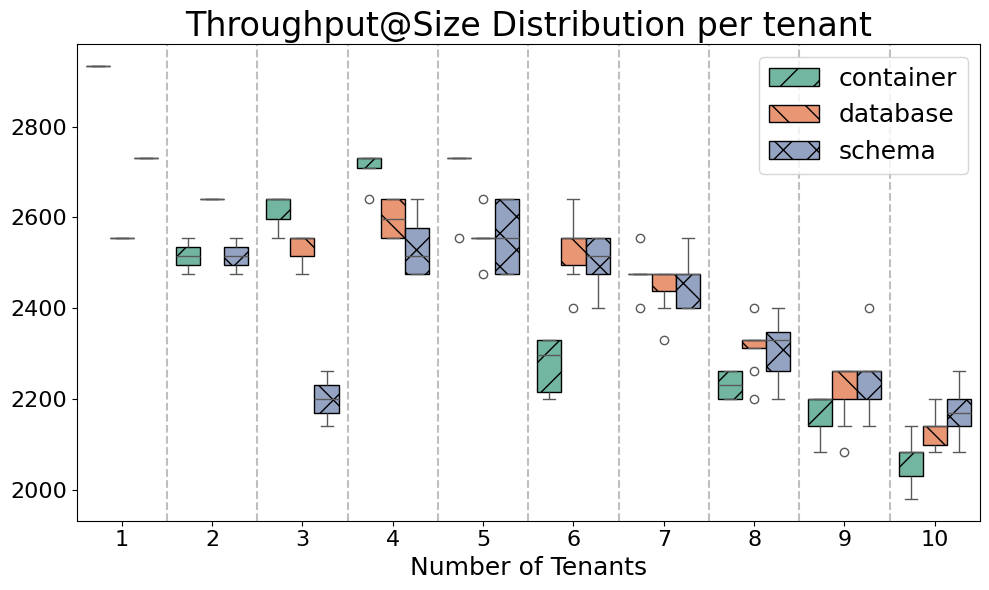

In [8]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Throughput@Size',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = "Throughput@Size Distribution per tenant"
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

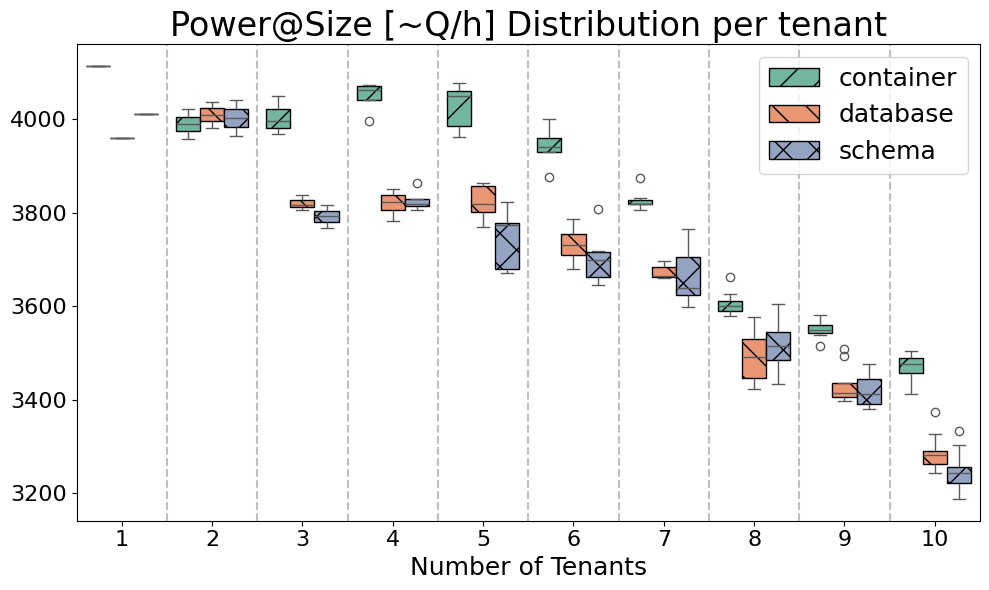

In [9]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Power@Size [~Q/h]',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = 'Power@Size [~Q/h] Distribution per tenant'
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

In [22]:
df_performance = get_performance_all(codes)
df_performance

,client,Throughput@Size,type,num_tenants
0,1,2933.33,container,1
1,2,2828.57,container,1
0,1,5029.84,container,2
1,2,5194.84,container,2
0,1,7834.84,container,3
1,2,8102.06,container,3
0,1,10833.09,container,4
1,2,10565.87,container,4
0,1,13478.96,container,5
1,2,12864.68,container,5


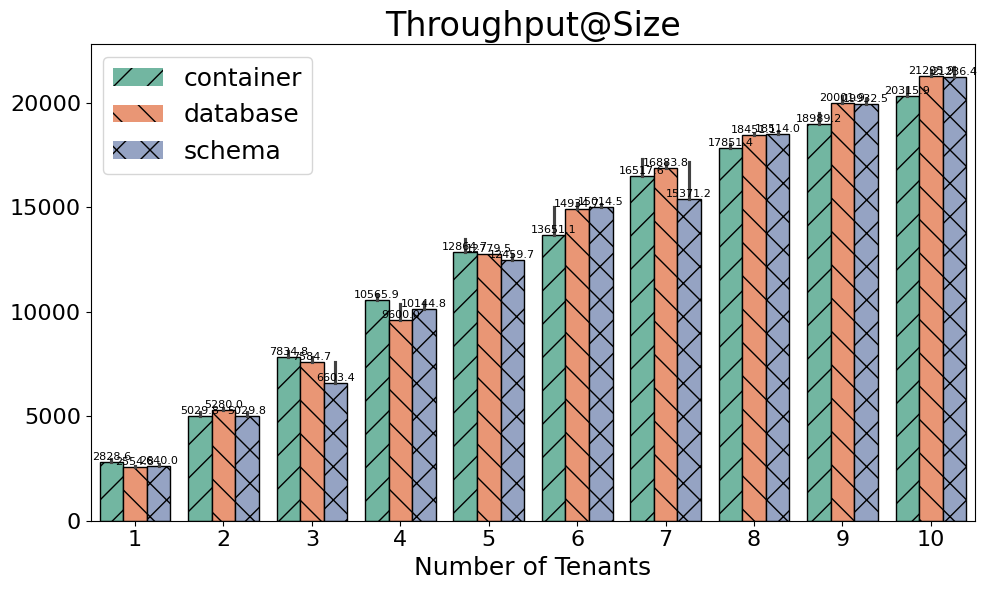

In [23]:
plot_bars(df_performance, y='Throughput@Size', title='Throughput@Size', estimator='min')

In [24]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-BHT-1-0-1-1,315.0,104.0,209.0,1,0,1,2757,container,1
PostgreSQL-BHT-1-0-2-1,315.0,104.0,209.0,1,0,2,2757,container,1
PostgreSQL-BHT-1-0-1-1,325.0,105.0,216.0,1,0,1,2757,container,2
PostgreSQL-BHT-1-0-2-1,325.0,105.0,216.0,1,0,2,2757,container,2
PostgreSQL-BHT-1-1-1-1,327.0,107.0,217.0,1,1,1,2757,container,2
PostgreSQL-BHT-1-1-2-1,327.0,107.0,217.0,1,1,2,2757,container,2
PostgreSQL-BHT-1-0-1-1,312.0,89.0,216.0,1,0,1,2757,container,3
PostgreSQL-BHT-1-0-2-1,312.0,89.0,216.0,1,0,2,2757,container,3
PostgreSQL-BHT-1-1-1-1,311.0,89.0,216.0,1,1,1,2757,container,3
PostgreSQL-BHT-1-1-2-1,311.0,89.0,216.0,1,1,2,2757,container,3


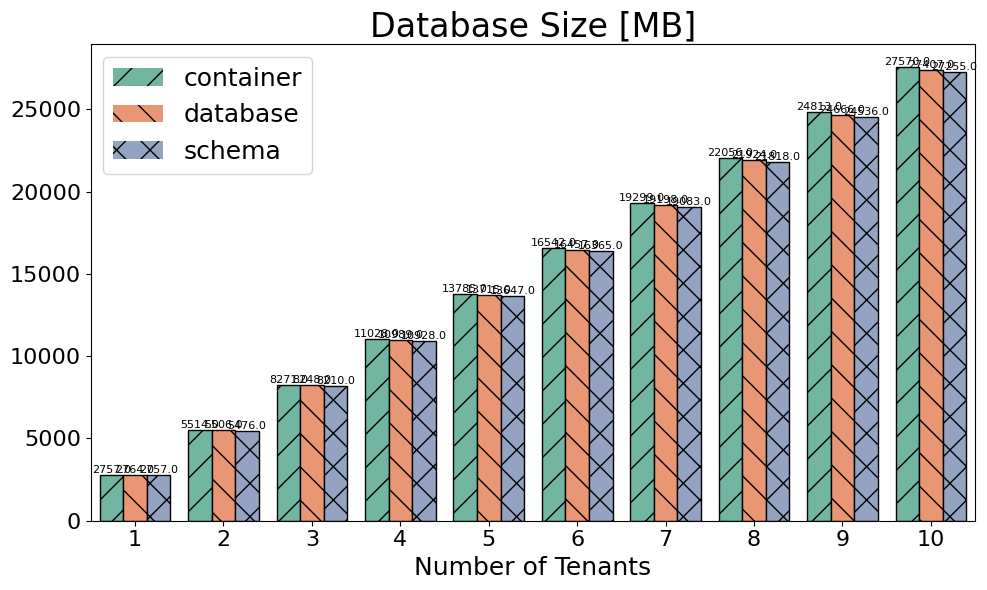

In [28]:
df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk']

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts

plot_bars(df, y='datadisk_normalized', title='Database Size [MB]', estimator='sum')

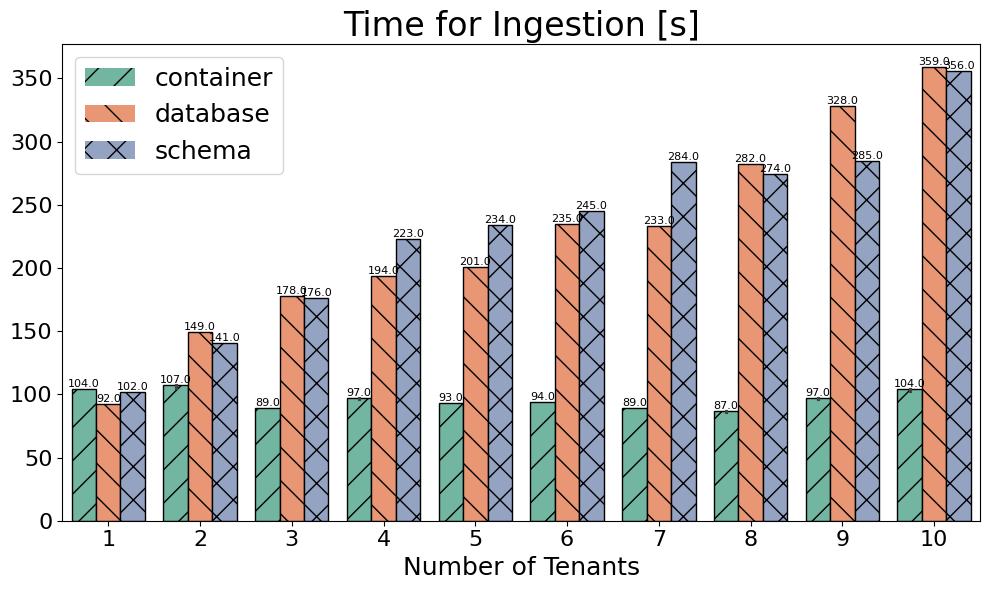

In [14]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

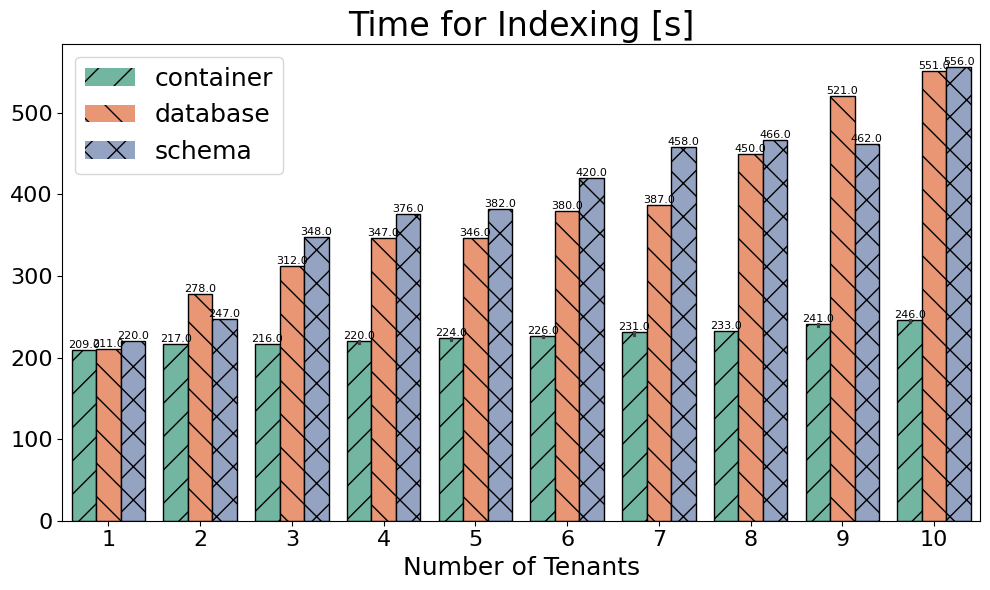

In [15]:
plot_bars(df_performance, y='time_check', title='Time for Indexing [s]', estimator='max')

In [16]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,88.96,3.75,5.38,1.60,container,1
0,1,162.57,11.00,14.24,0.00,container,2
0,1,149.85,11.13,16.00,2.64,container,3
0,1,274.91,15.08,21.56,2.33,container,4
0,1,590.60,19.05,27.15,6.52,container,5
0,1,580.74,22.68,32.62,3.55,container,6
0,1,901.66,26.67,38.01,4.53,container,7
0,1,1021.32,30.26,43.24,8.40,container,8
0,1,1371.40,34.35,48.93,5.59,container,9
0,1,1464.75,38.03,54.23,8.32,container,10


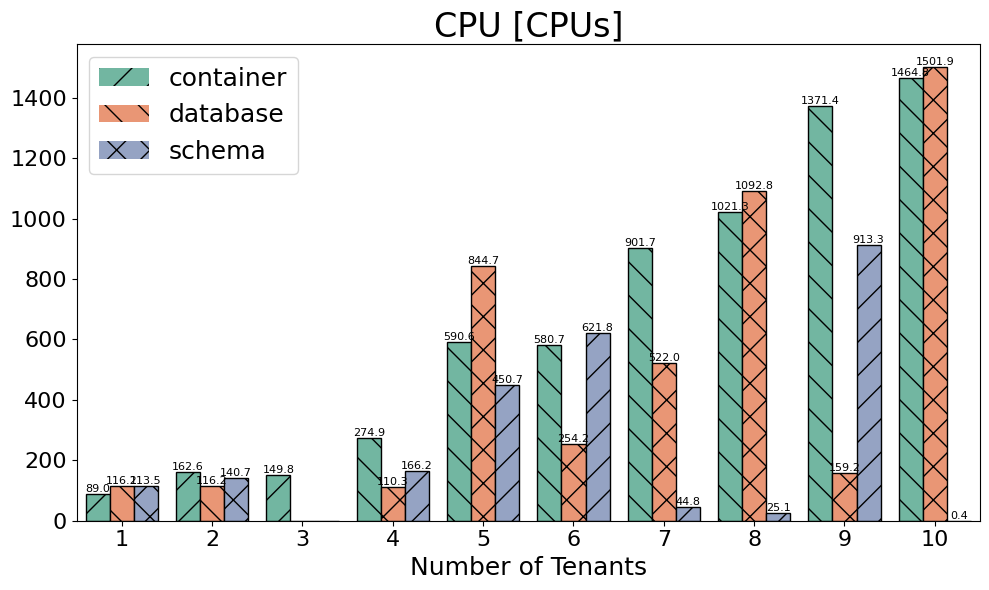

In [17]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

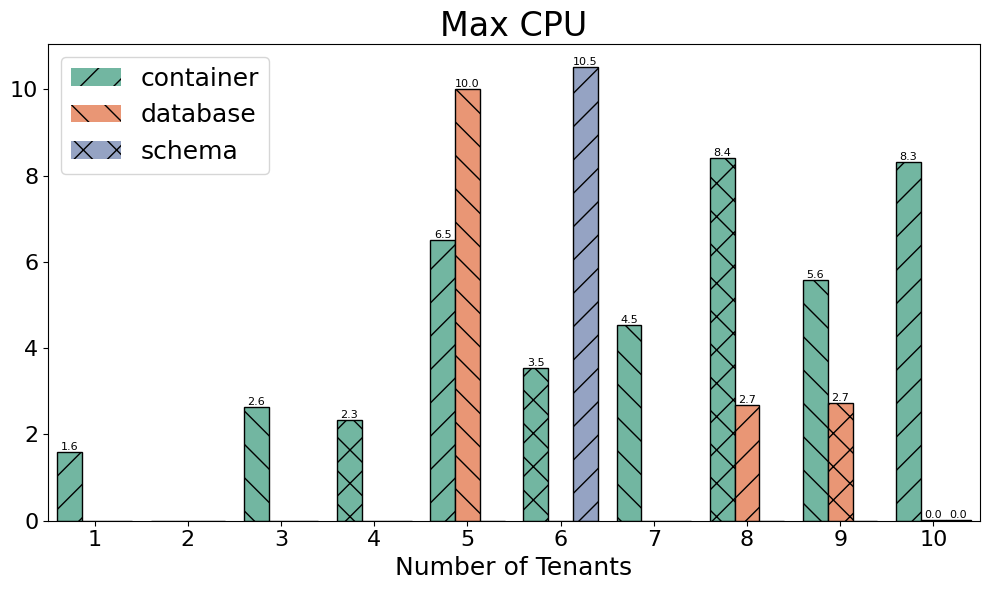

In [18]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

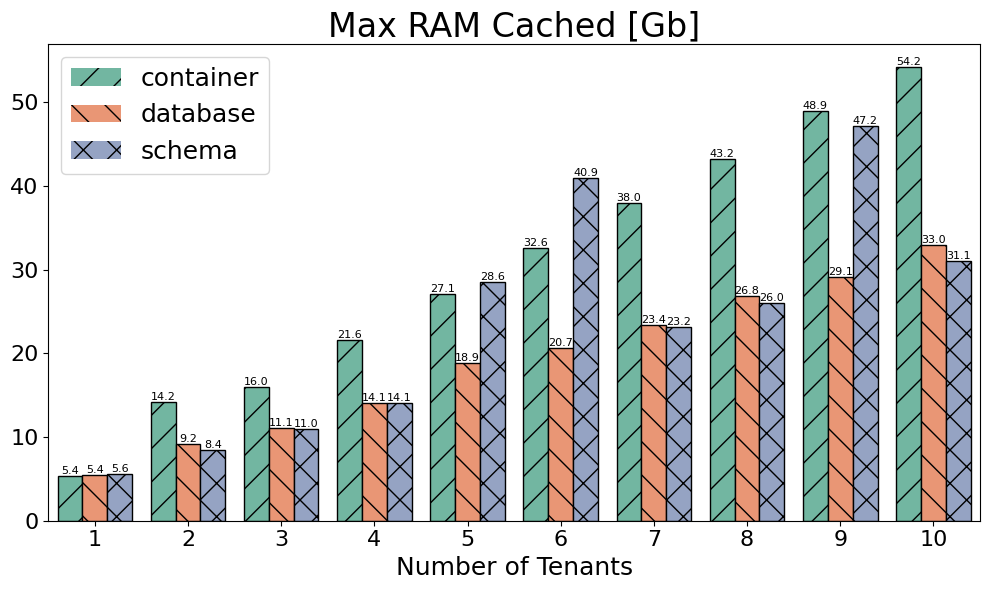

In [19]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

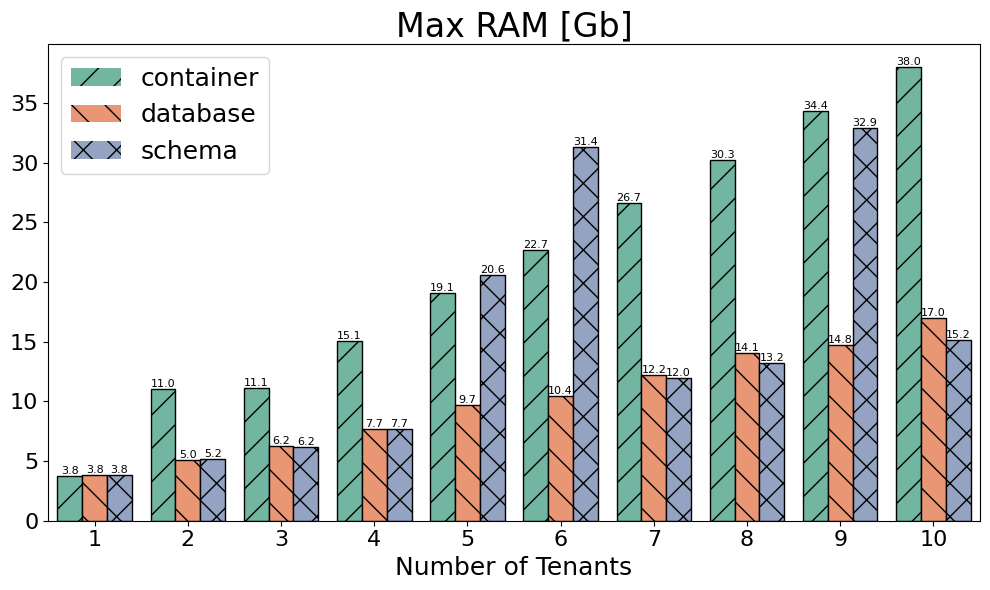

In [20]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

# Single Experiment

In [ ]:
code = '1750741356'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [ ]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

In [ ]:
get_loading_time_max(evaluation)

In [ ]:
get_monitoring_stream_single(evaluation).sort_values('client')

In [ ]:
get_monitoring_stream(evaluation)

In [ ]:
code=codes[9]
evaluate = inspector.inspector(path)
evaluate.load_experiment(code=code, silent=True)
query_properties = evaluate.get_experiment_query_properties()
query_properties

In [ ]:
print("\n### Power@Size ((3600*SF)/(geo times))")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index().astype('float')
df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
#df.columns = ['Power@Size [~Q/h]']
df_power = df.copy()
print(df.round(2))
print(parameter.defaultParameters['SF'])

In [ ]:
print("\n### Geometric Mean of Medians of Timer Run [s]")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index()
df.columns = ['Geo Times [s]']
df_geo_mean_runtime = df.copy()
print(df.round(2))


In [ ]:
df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
df

In [ ]:
#df_time = df.copy()
df_merged_time = pd.DataFrame()
for connection_nr, connection in evaluate.benchmarks.dbms.items():
    df_time = pd.DataFrame()
    c = connection.connectiondata
    connection_name = c['name']
    orig_name = c['orig_name']
    #print(orig_name)
    eva = evaluate.get_experiment_connection_properties(c['name'])
    df_time.index = [connection_name]
    #df_time['SF'] = int(SF)
    #print(c)
    #print(connection.name)
    #print(connection.connection)
    df_time['orig_name'] = orig_name
    df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
    df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
    #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
    df_time['num_experiment'] = int(c['parameter']['numExperiment'])
    df_time['num_client'] = int(c['parameter']['client'])
    df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
    df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
    df_time['benchmark_total_time'] = df_time['benchmark_end'] - df_time['benchmark_start']
    #print(df_time)
    df_merged_time = pd.concat([df_merged_time, df_time])

df_merged_time#.sort_values('orig_name')

In [ ]:
df = pd.concat([df, df_merged_time], axis=1)
df = df.sort_values('orig_name')
df

In [ ]:
df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
df

In [ ]:
def map_index_to_queryname(numQuery):
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery

def get_benchmark_df():
    code=codes[9]
    evaluate = inspector.inspector(path)
    evaluate.load_experiment(code=code, silent=True)
    query_properties = evaluate.get_experiment_query_properties()
    #print(query_properties)
    print(evaluate.e)#['connectionmanagement']['numRun'])
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        #print(df)
        num_of_queries = len(df.index)
    #print("\n### Power@Size ((3600*SF)/(geo times))")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    #df.columns = ['Power@Size [~Q/h]']
    df_power = df.copy()
    #print(df.round(2))
    #print(parameter.defaultParameters['SF'])
    #print("\n### Geometric Mean of Medians of Timer Run [s]")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    #print(df.round(2))
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    #df_time = df.copy()
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        #df_time['SF'] = int(SF)
        #print(c)
        #print(connection.name)
        #print(connection.connection)
        df_time['orig_name'] = orig_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    benchmark_count = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    #df_benchmark['Throughput@Size [~GB/h]'] = (22*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF']).round(2)
    index_names = list(df_benchmark.index.names)
    #print(index_names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    #print(df_benchmark)
    #return df_benchmark
    df.index = df.index.map(lambda x: str(x)[:-2])
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    #df = df.sort_values('orig_name')
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    return df

In [ ]:
get_benchmark_df()